# Unsupervised Anomaly Detection based on Forecasts

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do anomaly detection using Chronos's built-in model MTNet

For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction <a href="https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md" target="_blank">here</a>. In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>.

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_result_df(y_true_unscale, y_pred_unscale, ano_index, look_back,target_col='cpu_usage'):
    """
    Add prediction and anomaly value to dataframe.
    """
    result_df = pd.DataFrame({"y_true": y_true_unscale.squeeze(), "y_pred": y_pred_unscale.squeeze()})
    result_df['anomalies'] = 0
    result_df.loc[result_df.index[ano_index], 'anomalies'] = 1
    result_df['anomalies'] = result_df['anomalies'] > 0
    return result_df 

In [2]:
def plot_anomalies_value(date, y_true, y_pred, anomalies):
    """
    plot the anomalies value
    """
    fig, axs = plt.subplots(figsize=(16,6))
    
    axs.plot(date, y_true,color='blue', label='y_true')
    axs.plot(date, y_pred,color='orange', label='y_pred')
    axs.scatter(date[anomalies].tolist(), y_true[anomalies], color='red', label='anomalies value')
    axs.set_title('the anomalies value')
    
    plt.xlabel('datetime')
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe.Steps are as below:
* First, download the raw data <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>. Or run the script `get_data.sh` to download the raw data.It will download the resource usage of each machine from m_1932 to m_2085. 
* Second, run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932. Or run `extract_data.sh`.We use machine 1932 as an example in this notebook.You can choose any machines in the similar way.
* Finally, use pandas to load `m_1932.csv` into a dataframe as shown below.

In [3]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage","mem_usage"])

Below are some example records of the data

In [5]:
df_1932.head()

,time_step,cpu_usage,mem_usage
0,386640,41,92
1,386670,43,92
2,386690,44,92
3,386800,46,92
4,386930,44,93


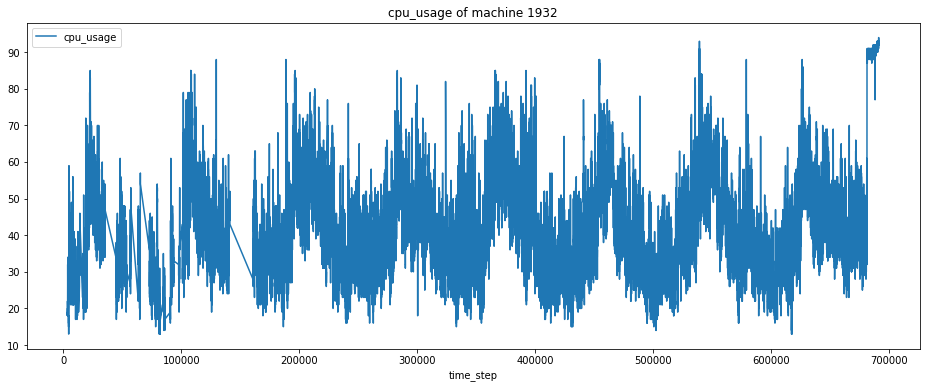

In [6]:
df_1932.sort_values(by="time_step", inplace=True)
df_1932.reset_index(inplace=True)
df_1932.sort_values(by="time_step").plot(y="cpu_usage", x="time_step", figsize=(16,6),title="cpu_usage of machine 1932")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the machine_usage data, the pre-processing convert the time step in seconds to timestamp starting from 2018-01-01.

In [7]:
df_1932.reset_index(inplace=True)
df_1932["time_step"] = pd.to_datetime(df_1932["time_step"], unit='s', origin=pd.Timestamp('2018-01-01'))

## Feature Engineering & Data Preperation

For feature engineering, we use hour as feature in addition to the target cpu usage.

For data preperation, we resample the average of cpu_usage in minutes, impute the data to handle missing data and scale the data. At last we generate the sample in numpy ndarray for Forecaster to use.

We generate a built-in TSDataset to complete the whole processing.

In [8]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

# we look back one hour data which is of the frequency of 1min.
look_back = 60
horizon = 1

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df_1932, dt_col="time_step", target_col="cpu_usage", with_split=True, val_ratio = 0.1, test_ratio=0.1)
standard_scaler = StandardScaler()

for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.resample(interval='1min', merge_mode="mean")\
          .impute(mode="last")\
          .gen_dt_feature()\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=look_back, horizon=horizon, feature_col = ["HOUR"])\

x_train, y_train = tsdata_train.to_numpy()
x_val, y_val = tsdata_val.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
y_train, y_val, y_test = y_train[:, 0, :], y_val[:, 0, :], y_test[:, 0, :]
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((9319, 60, 2), (9319, 1), (975, 60, 2), (975, 1), (991, 60, 2), (991, 1))

## Time series forecasting

In [9]:
from bigdl.chronos.forecaster.mtnet_forecaster import MTNetForecaster

First, we initialize a mtnet_forecaster according to input data shape. Specifcally, look_back should equal `(long_series_num+1)*series_length` . Details refer to chronos docs <a href="https://bigdl.readthedocs.io/en/latest/doc/Chronos/Overview/chronos.html" target="_blank">here</a>.

In [10]:
mtnet_forecaster = MTNetForecaster(target_dim=horizon,
                                   feature_dim=x_train.shape[-1],
                                   long_series_num=3,
                                   series_length=15
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


MTNet needs to preprocess the X into another format, so we call `MTNetForecaster.preprocess_input` on train_x and test_x.

In [11]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet_forecaster.preprocess_input(x_train)
x_val_mtnet = mtnet_forecaster.preprocess_input(x_val)
x_test_mtnet = mtnet_forecaster.preprocess_input(x_test)

Now we train the model and wait till it finished.

In [12]:
%%time
hist = mtnet_forecaster.fit(x = x_train_mtnet, y = y_train, batch_size=128, epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9319 samples
Epoch 1/20
9319/9319 [==============================] - 13s 1ms/sample - loss: 0.6441 - mean_squared_error: 0.6788
Epoch 2/20
9319/9319 [==============================] - 6s 613us/sample - loss: 0.4244 - mean_squared_error: 0.3265
Epoch 3/20
9319/9319 [==============================] - 6s 616us/sample - loss: 0.3594 - mean_squared_error: 0.2438
Epoch 4/20
9319/9319 [==============================] - 6s 614us/sample - loss: 0.3255 - mean_squared_error: 0.2043
Epoch 5/20
9319/9319 [==============================] - 6s 618us/sample - loss: 0.3080 - mean_squared_error: 0.1844
Epoch 6/20
9319/9319 [==============================] - 6s 614us/sample - loss: 0.3029 - mean_squared_error: 0.1802
Epoch 7/20
9319/9319 [==============================] - 6s 616us/sample - loss: 0.2935 - mean_squared_error: 0.1704
Epoch 8/20
9319/9319 [==============================] - 6s 615us/sample -

Use the model for prediction and inverse the scaling of the prediction results. 

In [13]:
y_pred_val = mtnet_forecaster.predict(x_val_mtnet)
y_pred_test = mtnet_forecaster.predict(x_test_mtnet)

In [14]:
y_pred_val_unscale = tsdata_val.unscale_numpy(np.expand_dims(y_pred_val, axis=1))[:, 0, :]
y_pred_test_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_pred_test, axis=1))[:, 0, :]
y_val_unscale = tsdata_val.unscale_numpy(np.expand_dims(y_val, axis=1))[:, 0, :]
y_test_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_test, axis=1))[:, 0, :]

Calculate the symetric mean absolute percentage error.

In [15]:
# evaluate with sMAPE
from bigdl.orca.automl.metrics import Evaluator
smape = Evaluator.evaluate("smape", y_test_unscale, y_pred_test_unscale)
print(f"sMAPE is {'%.2f' % smape}")

sMAPE is 4.44


## Anomaly detection

In [16]:
from bigdl.chronos.detector.anomaly import ThresholdDetector

ratio=0.01

thd=ThresholdDetector()
thd.set_params(ratio=ratio)
thd.fit(y_val_unscale,y_pred_val_unscale)
print("The threshold of validation dataset is:",thd.th)

The threshold of validation dataset is: 16.140777435302734


In [17]:
anomaly_scores_val = thd.score()
val_res_ano_idx = np.where(anomaly_scores_val > 0)[0]
print("The index of anomalies in validation dataset is:",val_res_ano_idx)

The index of anomalies in validation dataset is: [ 54 151 152 222 234 410 800 923 930 939]


In [18]:
anomaly_scores_test = thd.score(y_test_unscale,y_pred_test_unscale)
test_res_ano_idx = np.where(anomaly_scores_test > 0)[0]
print("The index of anoalies in test dataset is:",test_res_ano_idx)

The index of anoalies in test dataset is: [105 195 524 570 820 821 822 823]


Get a new dataframe which contains `y_true`，`y_pred`，`anomalies` value.

In [19]:
val_result_df = get_result_df(y_val_unscale, y_pred_val_unscale, val_res_ano_idx, look_back)
test_result_df = get_result_df(y_test_unscale, y_pred_test_unscale, test_res_ano_idx, look_back)

Draw anomalies in line chart.

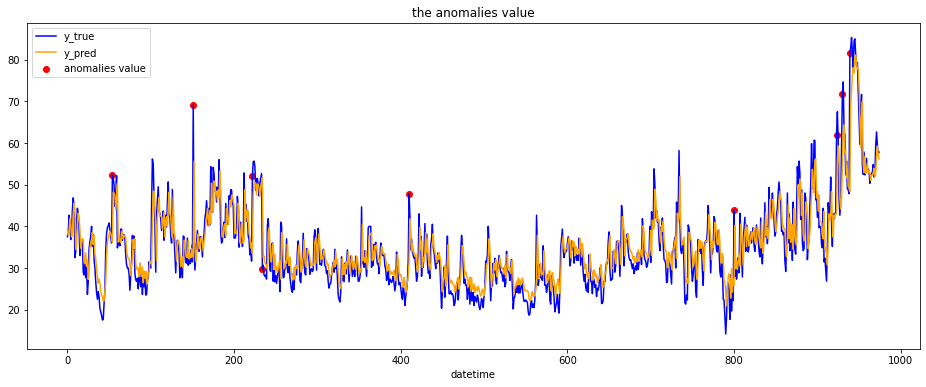

In [20]:
plot_anomalies_value(val_result_df.index, val_result_df.y_true, val_result_df.y_pred, val_result_df.anomalies)

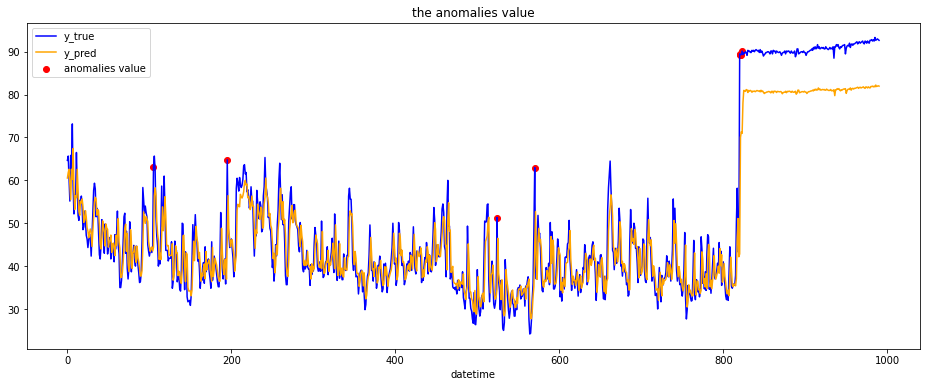

In [21]:
plot_anomalies_value(test_result_df.index, test_result_df.y_true, test_result_df.y_pred, test_result_df.anomalies)